# Text classification

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


import sklearn.linear_model
from sklearn.datasets import fetch_20newsgroups
import re
import nltk
from time import time
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
nltk.download('stopwords')
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nosov\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def clean_text(texts):
    """
    Return the cleaned text
    
    # Arguments
        texts: list of strings.
        
    # Returns
        list of strings
    """
    from nltk.corpus import stopwords
    stop_words = set(stopwords.words('english'))
    
    from nltk.stem.porter import PorterStemmer
    stemmer = PorterStemmer()
    
    HEADERS = [
    'From', 'Subject', 'To', 'Reply-To', 'In-Reply-To', 'Apparently-To',
    'Original-Sender', 'Originator', 'Moderator', 'Organization', 'Keywords',
    'Distribution', 'NNTP-Posting-Host', 'Lines', 'Summary', 'Supersedes',
    'X-Bytes', 'X-Disclaimer', 'X-Mailer', 'X-Newsreader', 'X-News-Reader',
    'X-Gated-By', 'X-Added', 'X-Status',
    'OD-Comment-To', 'Expires', 'Disclaimer', 'Article-I.D.', 
    'News-Software',  'Nf-ID', 'Mime-Version'
    ]
    
    corpus = []
    #remove ...
    for i in range(0, len(texts)):
        t = texts[i]
        
        for h in HEADERS:
            t = re.sub(r'.*'+h+':.*', '', t) #header
        
        t = re.sub(r'[\w\.-]+@[\w\.-]+', '', t) # email
        t = re.sub(r"\n", " ", t) # newline char
        t = re.sub('[^a-zA-Z]', ' ', t) #numbers
        t = t.lower() # to lowercase
        t = t.split()
        t = [w for w in t if not w in stop_words] #remove stopwords
        stemmer = PorterStemmer() 
        t = [stemmer.stem(w) for w in t] #stem words
        t = ' '.join(t)
        corpus.append(t)
        
    return corpus

In [3]:
class NeuralNet:
    
    
    def __init__(self, normalize = True, learning_rate = 0.01, max_iter = 30000, hidden_layer_sizes=(100,), \
                 beta=0.999, epsilon=1e-8, tol=1e-6, batch_size=64):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.normalize = normalize
        self.hidden_layer_sizes = hidden_layer_sizes
        self.n_layers = 1 + len(hidden_layer_sizes)
        self.epsilon = epsilon
        self.tol = tol
        self.beta = beta
        self.batch_size = batch_size
    
    def __normalize(self, X, mean = None, std = None):
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X - m) / s**2
        return X_new, m, s

    def __sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))
    
    def softmax(self, Z):
        expZ = np.exp(Z - np.max(Z))
        return expZ / expZ.sum(axis=0, keepdims=True)
    
    def __initialize_parameters(self, n_x, hidden_layers, n_y):
        np.random.seed(1)
        W = list()
        b = list()
        self.S_dW = list()
        self.S_db = list()
        
        h = list(hidden_layers)
        h.insert(0, n_x)
        h.append(n_y)
        hidden_layers = tuple(h)
        
        for i in range(1, self.n_layers+1):
            W.append(np.random.randn(hidden_layers[i], hidden_layers[i-1]) / np.sqrt(
                hidden_layers[i - 1]))
            b.append(np.zeros((hidden_layers[i], 1)))
            
            self.S_dW.append(np.zeros((hidden_layers[i], hidden_layers[i-1])))
            self.S_db.append(np.zeros((hidden_layers[i], 1)))

        self.parameters = {"W" : W, "b" : b}
    
    def __forward_propagation(self, X):
        W = self.parameters["W"]
        b = self.parameters["b"]

        A = list()
        Z = list()
               
        for i in range(0, self.n_layers-1):
            if i == 0:
                Z.append(np.dot(W[i], X) + b[i])
            else:
                Z.append(np.dot(W[i], A[i-1]) + b[i])
            A.append(self.__sigmoid(Z[i]))
        
        Z.append(np.dot(W[-1], A[-1]) + b[-1])
        A.append(self.softmax(Z[-1]))
        
        cache = (W, b, Z, A)

        return A[-1], cache
    
    def __sigmoid_derivative(self, Z):
        s = 1 / (1 + np.exp(-Z))
        return np.multiply(s, (1 - s))
    
    def cross_entropy(self, A, Y):
        return - np.sum(np.log(A) * (Y), axis=1)
    
    def compute_cost(self, A, Y):
        J = -np.mean(Y.T * np.log(A.T+ 1e-8))
        return J
        
    def __backward_propagation(self, X, Y, cache):
        m = X.shape[1]
        n = X.shape[0]
        (W, b, Z, A) = cache
        
        dW = [None] * (self.n_layers)
        dA = [None] * (self.n_layers)
        dZ = [None] * (self.n_layers)
        db = [None] * (self.n_layers)
        
        dZ[-1] = (A[-1] - Y)
        dW[-1] = (1. / m * np.dot(dZ[-1], A[-2].T))
        db[-1] = (1. / m * np.sum(dZ[-1], axis = 1, keepdims = True))
        dA[-1] = np.dot(W[-1].T, dZ[-1])
        
        for i in range(self.n_layers-1, 0, -1):
            dZ[i-1] = np.multiply(dA[i], self.__sigmoid_derivative(Z[i-1]))
            if i-1 == 0:
                dW[i-1] = 1. / m * np.dot(dZ[i-1], X.T)
            else:
                dW[i-1] = 1. / m * np.dot(dZ[i-1], A[i-2].T)
            db[i-1] = 1. / m * np.sum(dZ[i-1], axis = 1, keepdims = True) 
            dA[i-1] = np.dot(W[i-1].T, dZ[i-1])
        
        grads = {"dZ" : dZ, "dW" : dW, "db" : db}
        return grads
    
    def __update_parameters(self, grads):
        W = self.parameters["W"]
        b = self.parameters["b"]

        dW = grads["dW"]
        db = grads["db"]
        
        for i in range(self.n_layers):
            self.S_dW[i] = self.beta * self.S_dW[i] + (1 - self.beta) * np.power(dW[i], 2)
            self.S_db[i] = self.beta * self.S_db[i] + (1 - self.beta) * np.power(db[i], 2)
            W[i] = W[i] - self.learning_rate * dW[i] / (np.sqrt(self.S_dW[i]) + self.epsilon)
            b[i] = b[i] - self.learning_rate * db[i] / (np.sqrt(self.S_db[i]) + self.epsilon)
            
        self.parameters = {"W" : W, "b" : b}
        
    def create_mini_batches(self, X, Y, batch_size): 
        m = X.shape[1]
        mini_batches = [] 
        
        batch_size = self.batch_size if self.batch_size != None else m
        
        permutation = list(np.random.permutation(m))
        shuffled_X = X[:, permutation]
        
        shuffled_Y = Y[:, permutation]
         
        n_minibatches = m // batch_size 

        for i in range(n_minibatches + 1): 
            X_mini = shuffled_X[:, i*batch_size : (i + 1)*batch_size]
            Y_mini = shuffled_Y[:, i*batch_size : (i + 1)*batch_size] 
            mini_batches.append((X_mini, Y_mini)) 
        if m % batch_size != 0: 
            X_mini = shuffled_X[:, i*batch_size:]
            Y_mini = shuffled_Y[:, i*batch_size:]
            mini_batches.append((X_mini, Y_mini)) 
        return mini_batches 

    def fit(self, X_vert, Y_vert, print_cost = True):
        self.n_iter = 0
        X, Y = X_vert.T, Y_vert.T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        costs = []
        cost_history = []
        
        m = X.shape[1]
        n_x = X.shape[0]
        n_y = Y.shape[0]
        
        self.__initialize_parameters(n_x, self.hidden_layer_sizes, n_y)

        
        
        for i in range(self.max_iter):
            self.n_iter = i
            
            mini_batches = self.create_mini_batches(X, Y, self.batch_size)
            
            for (mini_X, mini_Y) in mini_batches:
                A, cache = self.__forward_propagation(mini_X)

                cost = self.compute_cost(A, mini_Y)

                grads = self.__backward_propagation(mini_X, mini_Y, cache)

                self.__update_parameters(grads)
            
            cost_history.append(cost)
            
            if print_cost and i % 10 == 0:
                print("{}-th iteration: {}".format(i, cost))

            #if i % 10 == 0:
            costs.append(cost)
  
            if i > 1 and abs(cost-cost_history[-2]) < self.tol:
                break

        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration")
            plt.show()
    
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        
        probs = self.__forward_propagation(X)[0]
        
        return probs.T
    
    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)
        y_pred = self.to_classlabel(positive_probs)
        return y_pred  

    def to_classlabel(self, z):
        return z.argmax(axis=1)

In [4]:
# Getting our data
df = fetch_20newsgroups(subset="all", shuffle=False)

In [5]:
len(df.data)

18846

In [6]:
df.data[0:2]

["From: cubbie@garnet.berkeley.edu (                               )\nSubject: Re: Cubs behind Marlins? How?\nArticle-I.D.: agate.1pt592$f9a\nOrganization: University of California, Berkeley\nLines: 12\nNNTP-Posting-Host: garnet.berkeley.edu\n\n\ngajarsky@pilot.njin.net writes:\n\nmorgan and guzman will have era's 1 run higher than last year, and\n the cubs will be idiots and not pitch harkey as much as hibbard.\n castillo won't be good (i think he's a stud pitcher)\n\n       This season so far, Morgan and Guzman helped to lead the Cubs\n       at top in ERA, even better than THE rotation at Atlanta.\n       Cubs ERA at 0.056 while Braves at 0.059. We know it is early\n       in the season, we Cubs fans have learned how to enjoy the\n       short triumph while it is still there.\n",
 'From: gnelson@pion.rutgers.edu (Gregory Nelson)\nSubject: Thanks Apple: Free Ethernet on my C610!\nArticle-I.D.: pion.Apr.6.12.05.34.1993.11732\nOrganization: Rutgers Univ., New Brunswick, N.J.\nLines: 26

In [7]:
print(df.data[0])

From: cubbie@garnet.berkeley.edu (                               )
Subject: Re: Cubs behind Marlins? How?
Article-I.D.: agate.1pt592$f9a
Organization: University of California, Berkeley
Lines: 12
NNTP-Posting-Host: garnet.berkeley.edu


gajarsky@pilot.njin.net writes:

morgan and guzman will have era's 1 run higher than last year, and
 the cubs will be idiots and not pitch harkey as much as hibbard.
 castillo won't be good (i think he's a stud pitcher)

       This season so far, Morgan and Guzman helped to lead the Cubs
       at top in ERA, even better than THE rotation at Atlanta.
       Cubs ERA at 0.056 while Braves at 0.059. We know it is early
       in the season, we Cubs fans have learned how to enjoy the
       short triumph while it is still there.



In [8]:
# Clean data
t = clean_text(df.data[0:1])
print(t)

['write morgan guzman era run higher last year cub idiot pitch harkey much hibbard castillo good think stud pitcher season far morgan guzman help lead cub top era even better rotat atlanta cub era brave know earli season cub fan learn enjoy short triumph still']


In [9]:
t0 = time()
corpus = clean_text(df.data)
print("done in %fs" % (time() - t0))

done in 329.841391s


In [10]:
corpus[0:2]

['write morgan guzman era run higher last year cub idiot pitch harkey much hibbard castillo good think stud pitcher season far morgan guzman help lead cub top era even better rotat atlanta cub era brave know earli season cub fan learn enjoy short triumph still',
 'well got centri yesterday took two week place order dealer rutger comput store appolog appl made substitut order order one without ethernet substitut one ethernet want know would alright must backlog centri w ethernet ship anyway happi except nosi decid open power first time scsi cabl hard drive partial connect must come loos ship big deal would piss tri boot come hard drive also annoy high pitch whine heard appl exchang complain might tri get swap also dissappiont lack soft power mention literatur saw also locat reset interupt button aw keyboard control function much conveni oh screen seem tojump wierd way power seen mention other must featur anyway fast great machin great price']

In [11]:
df.target

array([ 9,  4, 11, ...,  4,  6,  7])

In [12]:
df.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [13]:
len(df.target_names)

20

In [14]:
len(corpus)

18846

In [15]:
# Frame of cleaned text and targets
df2 = pd.DataFrame.from_dict({ 'text': corpus, 'group': np.take(df.target_names, df.target) })
df2

,text,group
0,write morgan guzman era run higher last year c...,rec.sport.baseball
1,well got centri yesterday took two week place ...,comp.sys.mac.hardware
2,histori classic method modern method survey re...,sci.crypt
3,attent mac quadra owner mani storag industri e...,comp.sys.mac.hardware
4,robert beauchain write show exampl other provi...,alt.atheism
...,...,...
18841,nntp post host well sf ca us circuit board gre...,sci.electronics
18842,articl r write bike luckili guy stop foot behi...,rec.motorcycles
18843,told resolut fge could go x fg could go x anyb...,comp.sys.mac.hardware
18844,cad setup sale g plb local bu motherboard use ...,misc.forsale


In [16]:
# Split into train dataset and test dataset
train, test = train_test_split(df2, test_size=0.2, random_state=42, stratify=df2.group)

In [17]:
print("Train Set:", train.shape, "\nTest Set:", test.shape)

Train Set: (15076, 2) 
Test Set: (3770, 2)


In [18]:
# The most popular groups
print("Train Group:\n\n", train.group.value_counts(), "\n\n\nTest Group:\n\n", test.group.value_counts())

Train Group:

 rec.sport.hockey            799
soc.religion.christian      798
rec.motorcycles             797
rec.sport.baseball          795
sci.crypt                   793
rec.autos                   792
sci.med                     792
sci.space                   790
comp.windows.x              790
comp.os.ms-windows.misc     788
sci.electronics             787
comp.sys.ibm.pc.hardware    786
misc.forsale                780
comp.graphics               778
comp.sys.mac.hardware       770
talk.politics.mideast       752
talk.politics.guns          728
alt.atheism                 639
talk.politics.misc          620
talk.religion.misc          502
Name: group, dtype: int64 


Test Group:

 rec.sport.hockey            200
rec.motorcycles             199
rec.sport.baseball          199
soc.religion.christian      199
sci.crypt                   198
rec.autos                   198
sci.med                     198
comp.windows.x              198
sci.electronics             197
comp.os.ms-win

In [19]:
# Encoding target
label_encoder = LabelEncoder().fit(train.group)
label_encoder.classes_

array(['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc',
       'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
       'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles',
       'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt',
       'sci.electronics', 'sci.med', 'sci.space',
       'soc.religion.christian', 'talk.politics.guns',
       'talk.politics.mideast', 'talk.politics.misc',
       'talk.religion.misc'], dtype=object)

In [20]:
Y_train = label_encoder.transform(train.group)
print('Y_train: %s' % (Y_train.shape))

Y_test = label_encoder.transform(test.group)
print('Y_test: %s' % (Y_test.shape))

Y_train: 15076
Y_test: 3770


In [21]:
Y_train

array([ 5, 16,  1, ..., 14, 11, 16])

In [22]:
# Encoding text using bag of words
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=20).fit(train.text)
keys = sorted((key, token) for token, key in cv.vocabulary_.items())
keys

[(0, 'also'),
 (1, 'articl'),
 (2, 'ax'),
 (3, 'get'),
 (4, 'go'),
 (5, 'know'),
 (6, 'like'),
 (7, 'make'),
 (8, 'one'),
 (9, 'peopl'),
 (10, 'post'),
 (11, 'say'),
 (12, 'system'),
 (13, 'think'),
 (14, 'time'),
 (15, 'use'),
 (16, 'work'),
 (17, 'would'),
 (18, 'write'),
 (19, 'year')]

In [23]:
samples = corpus[0:10]
encoded = pd.DataFrame(data = cv.transform(samples).toarray(), columns = [token for key, token in keys])
encoded

,also,articl,ax,get,go,know,like,make,one,peopl,post,say,system,think,time,use,work,would,write,year
0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1
1,3,0,0,1,0,1,0,0,2,0,0,0,0,0,1,0,0,2,0,0
2,2,5,0,0,0,0,3,0,1,0,1,0,6,1,1,3,0,0,1,2
3,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,2,1,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,1
5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0
6,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,5,0,1,0
7,2,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0
8,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0
9,1,0,0,1,0,1,1,0,0,0,0,0,0,0,1,1,2,4,0,0


In [24]:
# Encoding text using TF-IDF
tfidf = TfidfVectorizer(max_features=20).fit(train.text)
keys = sorted((key, token) for token, key in tfidf.vocabulary_.items())
keys

[(0, 'also'),
 (1, 'articl'),
 (2, 'ax'),
 (3, 'get'),
 (4, 'go'),
 (5, 'know'),
 (6, 'like'),
 (7, 'make'),
 (8, 'one'),
 (9, 'peopl'),
 (10, 'post'),
 (11, 'say'),
 (12, 'system'),
 (13, 'think'),
 (14, 'time'),
 (15, 'use'),
 (16, 'work'),
 (17, 'would'),
 (18, 'write'),
 (19, 'year')]

In [25]:
samples = corpus[0:10]
encoded = pd.DataFrame(data = tfidf.transform(samples).toarray(), columns = [token for key, token in keys])
encoded

,also,articl,ax,get,go,know,like,make,one,peopl,post,say,system,think,time,use,work,would,write,year
0,0.000000,0.000000,0.0,0.000000,0.000000,0.477654,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.517155,0.000000,0.000000,0.000000,0.000000,0.354650,0.615322
1,0.737972,0.000000,0.0,0.215742,0.000000,0.216590,0.000000,0.0,0.387938,0.0,0.000000,0.0,0.000000,0.000000,0.240513,0.000000,0.000000,0.391918,0.000000,0.000000
2,0.209405,0.381375,0.0,0.000000,0.000000,0.000000,0.266805,0.0,0.082560,0.0,0.089213,0.0,0.757287,0.099812,0.102371,0.264039,0.000000,0.000000,0.068448,0.237518
3,0.370390,0.000000,0.0,0.000000,0.377573,0.000000,0.000000,0.0,0.292061,0.0,0.000000,0.0,0.000000,0.000000,0.362142,0.311350,0.000000,0.590113,0.242140,0.000000
4,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.824369,0.000000,0.000000,0.000000,0.000000,0.282664,0.490426
5,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.562804,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.599976,0.000000,0.568578,0.000000,0.000000
6,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.157413,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.980073,0.000000,0.121152,0.000000
7,0.736854,0.268397,0.0,0.323123,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.313923,0.0,0.000000,0.000000,0.000000,0.309701,0.000000,0.293493,0.000000,0.000000
8,0.000000,0.000000,0.0,0.000000,0.000000,0.911111,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.412162,0.000000,0.000000
9,0.226126,0.000000,0.0,0.198320,0.000000,0.199100,0.192073,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.221091,0.190082,0.478348,0.720538,0.000000,0.000000


In [26]:
# Vectorize text with TF-IDF
t0 = time()
tfidf = TfidfVectorizer(max_features=10000).fit(train.text)
len(tfidf.vocabulary_)
print("done in %fs" % (time() - t0))

done in 3.587027s


In [27]:
keys = sorted((key, token) for token, key in tfidf.vocabulary_.items())
keys[200:210]

[(200, 'akin'),
 (201, 'al'),
 (202, 'ala'),
 (203, 'alabama'),
 (204, 'alamo'),
 (205, 'alan'),
 (206, 'alarm'),
 (207, 'alaska'),
 (208, 'albani'),
 (209, 'albeit')]

In [28]:
t0 = time()
X_train = tfidf.transform(train.text).toarray()
print('X_train: %s' % (X_train.shape,))

X_test = tfidf.transform(test.text).toarray()
print('X_test: %s' % (X_test.shape,))
print("done in %fs" % (time() - t0))

X_train: (15076, 10000)
X_test: (3770, 10000)
done in 4.861389s


In [29]:
X_train[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [30]:
X_train[0].sum()

3.926679868086563

In [31]:
# Testing with sklearn MultinomialNB
clf = MultinomialNB().fit(X_train, Y_train)

In [32]:
#  Classification report for train set
print(classification_report(Y_train, clf.predict(X_train), target_names=label_encoder.classes_))

                          precision    recall  f1-score   support

             alt.atheism       0.89      0.80      0.84       639
           comp.graphics       0.85      0.87      0.86       778
 comp.os.ms-windows.misc       0.85      0.87      0.86       788
comp.sys.ibm.pc.hardware       0.78      0.87      0.82       786
   comp.sys.mac.hardware       0.92      0.90      0.91       770
          comp.windows.x       0.92      0.91      0.92       790
            misc.forsale       0.91      0.83      0.87       780
               rec.autos       0.94      0.93      0.94       792
         rec.motorcycles       0.95      0.97      0.96       797
      rec.sport.baseball       0.97      0.98      0.97       795
        rec.sport.hockey       0.95      0.98      0.97       799
               sci.crypt       0.91      0.95      0.93       793
         sci.electronics       0.91      0.86      0.88       787
                 sci.med       0.96      0.95      0.96       792
         

In [33]:
# Classification report for test set
print(classification_report(Y_test, clf.predict(X_test), target_names=label_encoder.classes_))

                          precision    recall  f1-score   support

             alt.atheism       0.86      0.75      0.80       160
           comp.graphics       0.73      0.81      0.77       195
 comp.os.ms-windows.misc       0.77      0.80      0.78       197
comp.sys.ibm.pc.hardware       0.72      0.77      0.74       196
   comp.sys.mac.hardware       0.85      0.80      0.82       193
          comp.windows.x       0.84      0.85      0.85       198
            misc.forsale       0.88      0.72      0.79       195
               rec.autos       0.88      0.86      0.87       198
         rec.motorcycles       0.91      0.95      0.93       199
      rec.sport.baseball       0.94      0.97      0.95       199
        rec.sport.hockey       0.92      0.94      0.93       200
               sci.crypt       0.86      0.93      0.89       198
         sci.electronics       0.85      0.78      0.81       197
                 sci.med       0.92      0.89      0.91       198
         

In [34]:
# Prediction
pred = clf.predict(X_test)
pred

array([ 1, 16,  5, ...,  4, 15, 17])

In [35]:
# Test set accuracy
accuracy_score(Y_test, pred)

0.8371352785145889

In [36]:
# Confusion matrix
print("Confusion matrix:")
pd.DataFrame(confusion_matrix(Y_test, pred))

Confusion matrix:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,120,1,0,0,1,0,0,0,1,0,0,0,0,2,0,26,3,5,0,1
1,0,158,7,6,4,9,1,2,0,0,1,4,1,1,1,0,0,0,0,0
2,0,6,158,14,1,12,0,1,0,2,0,1,0,0,2,0,0,0,0,0
3,0,4,15,150,8,3,5,1,1,0,1,0,6,1,0,0,0,1,0,0
4,0,5,4,11,155,1,3,1,1,1,0,5,6,0,0,0,0,0,0,0
5,0,14,5,3,1,169,0,0,1,1,0,1,0,0,2,1,0,0,0,0
6,0,1,1,14,8,2,140,7,4,1,5,3,5,1,2,1,0,0,0,0
7,0,1,2,2,1,0,3,171,7,2,1,0,1,3,0,1,3,0,0,0
8,0,0,2,0,0,0,2,1,189,1,1,0,0,0,1,0,2,0,0,0
9,0,0,1,0,0,0,0,1,0,193,3,0,0,0,1,0,0,0,0,0


In [37]:
# Testing with sklearn MLPClassifier
clf = MLPClassifier(alpha=1e-5, hidden_layer_sizes=(50,), random_state=42, early_stopping=True)
t0 = time()
clf.fit(X_train, Y_train)
print("done in %fs" % (time() - t0))

done in 152.380274s


In [38]:
# Classification report for train set
print(classification_report(Y_train, clf.predict(X_train), target_names=label_encoder.classes_))

                          precision    recall  f1-score   support

             alt.atheism       0.98      0.97      0.98       639
           comp.graphics       0.98      0.97      0.97       778
 comp.os.ms-windows.misc       0.97      0.97      0.97       788
comp.sys.ibm.pc.hardware       0.95      0.96      0.96       786
   comp.sys.mac.hardware       0.98      0.97      0.98       770
          comp.windows.x       0.96      0.99      0.97       790
            misc.forsale       0.95      0.97      0.96       780
               rec.autos       0.98      0.99      0.98       792
         rec.motorcycles       1.00      0.99      0.99       797
      rec.sport.baseball       0.99      1.00      1.00       795
        rec.sport.hockey       1.00      0.99      0.99       799
               sci.crypt       0.99      0.99      0.99       793
         sci.electronics       0.97      0.97      0.97       787
                 sci.med       0.98      0.99      0.99       792
         

In [39]:
# Classification report for test set
print(classification_report(Y_test, clf.predict(X_test), target_names=label_encoder.classes_))

                          precision    recall  f1-score   support

             alt.atheism       0.86      0.82      0.84       160
           comp.graphics       0.81      0.85      0.83       195
 comp.os.ms-windows.misc       0.81      0.84      0.82       197
comp.sys.ibm.pc.hardware       0.77      0.78      0.77       196
   comp.sys.mac.hardware       0.87      0.84      0.85       193
          comp.windows.x       0.82      0.88      0.85       198
            misc.forsale       0.85      0.84      0.84       195
               rec.autos       0.89      0.91      0.90       198
         rec.motorcycles       0.96      0.90      0.93       199
      rec.sport.baseball       0.95      0.97      0.96       199
        rec.sport.hockey       0.98      0.94      0.96       200
               sci.crypt       0.95      0.93      0.94       198
         sci.electronics       0.85      0.84      0.84       197
                 sci.med       0.93      0.91      0.92       198
         

In [40]:
# Prediction
pred = clf.predict(X_test)
pred

array([ 1, 19,  5, ...,  4, 15, 17])

In [41]:
# Test set accuracy
accuracy_score(Y_test, pred)

0.883289124668435

In [42]:
# Confusion matrix
print("Confusion matrix:")
pd.DataFrame(confusion_matrix(Y_test, pred))

Confusion matrix:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,132,1,0,0,0,0,0,0,0,0,0,2,0,2,0,5,2,2,1,13
1,0,166,5,4,3,11,1,0,0,1,0,1,3,0,0,0,0,0,0,0
2,0,3,165,13,2,11,1,0,0,0,0,1,0,0,1,0,0,0,0,0
3,0,5,14,152,6,1,9,1,0,0,0,0,6,2,0,0,0,0,0,0
4,0,5,4,9,162,1,3,0,1,0,0,1,6,0,0,0,0,0,1,0
5,0,12,5,2,1,174,0,2,0,1,0,0,0,0,1,0,0,0,0,0
6,0,1,1,6,6,5,163,3,2,0,2,1,5,0,0,0,0,0,0,0
7,0,0,0,3,0,1,4,181,3,1,0,0,2,2,0,0,0,0,0,1
8,0,1,1,0,0,1,2,8,179,1,0,0,0,1,0,0,2,1,0,2
9,0,0,0,0,0,0,1,0,0,194,2,0,1,0,1,0,0,0,0,0


In [43]:
# Encoding target with OneHotEncoder
encoder = OneHotEncoder()
Y_train_e = encoder.fit_transform(Y_train.reshape(-1, 1)).toarray()
Y_train_e.shape

(15076, 20)

In [44]:
# Testing with Custom Neural Network
cls = NeuralNet(normalize = False, learning_rate = 0.1, max_iter = 30, hidden_layer_sizes=(50,),beta = 0.999, epsilon=1e-8, tol=1e-6, batch_size=4096)

0-th iteration: 0.14524861624005658
10-th iteration: 0.0042391509200391505
20-th iteration: 0.0025438128870915503


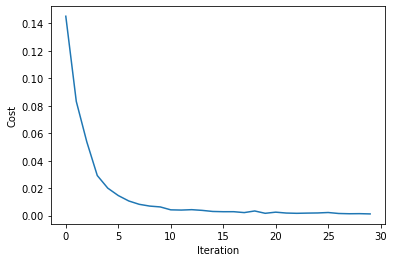

done in 145.127550s


In [45]:
t0 = time()
cls.fit(X_train, Y_train_e)
print("done in %fs" % (time() - t0))

In [46]:
# Classification report for train set
print(classification_report(Y_train, cls.predict(X_train), target_names=label_encoder.classes_))

                          precision    recall  f1-score   support

             alt.atheism       1.00      0.97      0.98       639
           comp.graphics       1.00      0.99      0.99       778
 comp.os.ms-windows.misc       0.99      0.99      0.99       788
comp.sys.ibm.pc.hardware       0.99      0.99      0.99       786
   comp.sys.mac.hardware       0.99      0.99      0.99       770
          comp.windows.x       1.00      0.99      0.99       790
            misc.forsale       0.98      0.99      0.98       780
               rec.autos       1.00      0.99      0.99       792
         rec.motorcycles       1.00      1.00      1.00       797
      rec.sport.baseball       1.00      1.00      1.00       795
        rec.sport.hockey       1.00      1.00      1.00       799
               sci.crypt       0.99      1.00      0.99       793
         sci.electronics       0.99      0.99      0.99       787
                 sci.med       1.00      1.00      1.00       792
         

In [47]:
# Classification report for test set
print(classification_report(Y_test, cls.predict(X_test), target_names=label_encoder.classes_))

                          precision    recall  f1-score   support

             alt.atheism       0.74      0.77      0.75       160
           comp.graphics       0.73      0.69      0.71       195
 comp.os.ms-windows.misc       0.74      0.74      0.74       197
comp.sys.ibm.pc.hardware       0.61      0.70      0.65       196
   comp.sys.mac.hardware       0.74      0.71      0.73       193
          comp.windows.x       0.81      0.82      0.82       198
            misc.forsale       0.65      0.67      0.66       195
               rec.autos       0.80      0.81      0.81       198
         rec.motorcycles       0.94      0.83      0.88       199
      rec.sport.baseball       0.90      0.90      0.90       199
        rec.sport.hockey       0.93      0.92      0.92       200
               sci.crypt       0.89      0.89      0.89       198
         sci.electronics       0.79      0.77      0.78       197
                 sci.med       0.87      0.85      0.86       198
         

In [48]:
# Prediction
Y_predd = cls.predict_proba(X_test)
print(Y_predd.shape) 

(3770, 20)


In [49]:
Y_predd

array([[1.90938611e-07, 9.99045660e-01, 4.02490469e-05, ...,
        1.17878663e-07, 1.21152937e-04, 4.70503757e-08],
       [1.51225203e-02, 1.87735573e-08, 5.98092648e-06, ...,
        5.64351780e-03, 6.51279545e-06, 9.78785487e-01],
       [5.35505203e-08, 3.25533710e-05, 5.56964488e-05, ...,
        2.16787684e-04, 3.51140143e-07, 4.77899183e-05],
       ...,
       [2.13346770e-04, 3.78630660e-03, 6.37596013e-04, ...,
        4.53698236e-05, 2.72709319e-04, 1.05202688e-04],
       [4.26890526e-03, 2.75695878e-05, 7.38582318e-06, ...,
        1.40253920e-03, 2.79141343e-03, 1.03569247e-02],
       [1.45104781e-04, 7.16972579e-04, 1.03937311e-05, ...,
        7.43661209e-01, 1.21444159e-02, 7.51559477e-06]])

In [50]:
Y_predd[0][0:20].sum()

0.9999999999999998

In [51]:
Y_hat = cls.predict(X_test)
Y_hat

array([ 1, 19,  5, ...,  4, 15, 17], dtype=int64)

In [52]:
# Test set accuracy
accuracy_score(Y_test, Y_hat)

0.806631299734748

In [53]:
# Confusion matrix
print("Confusion matrix:")
pd.DataFrame(confusion_matrix(Y_test, pred))

Confusion matrix:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,132,1,0,0,0,0,0,0,0,0,0,2,0,2,0,5,2,2,1,13
1,0,166,5,4,3,11,1,0,0,1,0,1,3,0,0,0,0,0,0,0
2,0,3,165,13,2,11,1,0,0,0,0,1,0,0,1,0,0,0,0,0
3,0,5,14,152,6,1,9,1,0,0,0,0,6,2,0,0,0,0,0,0
4,0,5,4,9,162,1,3,0,1,0,0,1,6,0,0,0,0,0,1,0
5,0,12,5,2,1,174,0,2,0,1,0,0,0,0,1,0,0,0,0,0
6,0,1,1,6,6,5,163,3,2,0,2,1,5,0,0,0,0,0,0,0
7,0,0,0,3,0,1,4,181,3,1,0,0,2,2,0,0,0,0,0,1
8,0,1,1,0,0,1,2,8,179,1,0,0,0,1,0,0,2,1,0,2
9,0,0,0,0,0,0,1,0,0,194,2,0,1,0,1,0,0,0,0,0
